Import Libs

In [1]:
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

Function to download and plot Historical Stock Prices from Yahoo Finance


In [2]:
import matplotlib.pyplot as plt
import yfinance

def download_historical_data(name, start_date, end_date, n_forward=2, plot=True):
    """
    Downloads historical stock data for a given ticker symbol within a specified date range.
    
    Args:
        name (str): The ticker symbol of the stock.
        start_date (str): The start date of the historical data in the format 'YYYY-MM-DD'.
        end_date (str): The end date of the historical data in the format 'YYYY-MM-DD'.
        n_forward (int, optional): The number of days to shift the close price forward. Defaults to 2.
        plot (bool, optional): Whether to plot the closing price. Defaults to True.
    
    Returns:
        pandas.DataFrame: A DataFrame containing the historical stock data with additional columns for the forward close price and return.
    """
    ticker = yfinance.Ticker(name)
    data = ticker.history(interval="1d", start=start_date, end=end_date)
    data['Forward Close'] = data['Close'].shift(-n_forward)
    data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close']

    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(data['Close'])
        plt.title(name + ' close price')
        plt.show()

    return data

Donwload data

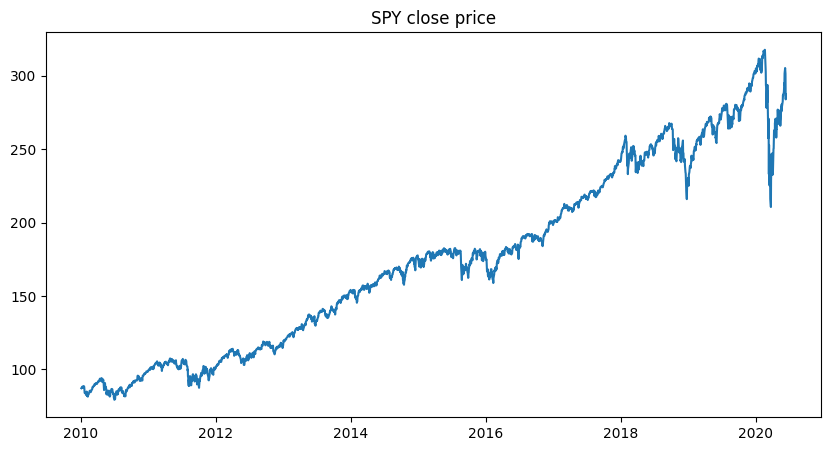

In [3]:
n_forward = 40

# data = download_historical_data(name='BTC-USD',
data = download_historical_data(name='SPY',
                                start_date='2010-01-01',
                                end_date='2020-06-15',
                                n_forward=n_forward,
                                plot=True)

## Function Backtest SMA 

In [4]:
def perform_sma_backtest(data, train_size=0.6, sma_range=range(20, 500), ascending=True):
    """
    Perform a simple moving average (SMA) backtest on stock trading data.

    Args:
        data (DataFrame): The input stock trading data.
        train_size (float, optional): The proportion of data to be used for training. Defaults to 0.6.
        sma_range (range, optional): The range of SMA lengths to test. Defaults to range(20, 500).
        ascending (bool, optional): Whether to sort the result in ascending order of training forward return. Defaults to True.

    Returns:
        list: A list of dictionaries containing the SMA length, training forward return, test forward return, and p-value for each SMA length.

    """
    from scipy.stats import ttest_ind
    result = []
    for sma_length in sma_range:
        # Calculate Simple Moving Average (SMA) for the given length and store it in a new column in the data DataFrame
        data['SMA'] = data['Close'].rolling(sma_length).mean()
        
        # Create a new column 'input' in the data DataFrame, which is 1 if the 'Close' price is greater than the SMA, else 0
        data['input'] = [int(x) for x in data['Close'] > data['SMA']]
        
        # Drop any rows in the data DataFrame that contain NaN values
        df = data.dropna()
        
        # Split the DataFrame into a training set and a test set
        training = df.head(int(train_size * df.shape[0]))
        test = df.tail(int((1 - train_size) * df.shape[0]))
        
        # Calculate the mean forward return for the training and test sets where 'input' is 1
        tr_returns = training[training['input'] == 1]['Forward Return']
        test_returns = test[test['input'] == 1]['Forward Return']
        mean_forward_return_training = tr_returns.mean()
        mean_forward_return_test = test_returns.mean()
        
        # Perform a t-test to compare the means of the two samples (training and test returns)
        pvalue = ttest_ind(tr_returns, test_returns, equal_var=False)[1]
        
        # Append the results to the result list
        result.append({
            'sma_length': sma_length,
            'training_forward_return': mean_forward_return_training,
            'test_forward_return': mean_forward_return_test,
            'p-value': pvalue
        })    
    # sort the result by "Training Forward Return"
    if ascending:
        result.sort(key=lambda x: -x['training_forward_return'])
    return result

Perfom Backtest and print result

In [5]:
# Perform a simple moving average (SMA) backtest on the stock trading data
result = perform_sma_backtest(data)

# get sma with highest training forward return
sma = result[0]

# print all information of the best sma
print("Best SMA length:", sma['sma_length'])
print("Training forward return:", sma['training_forward_return'])
print("Test forward return:", sma['test_forward_return'])
print("P-value:", sma['p-value'])

# check if the p-value is less than 0.05 ( significance level)
if sma['p-value'] < 0.05:
    print("The p-value is less than 0.05, so we reject the null hypothesis.")
else:
    print("\nThe p-value is greater than 0.05, so we fail to reject the null hypothesis.")
    print("The mean of the training forward return is EQUAL to the mean of the test forward return.")

# null hypothesis: the mean of the training forward return is equal to the mean of the test forward return
# alternative hypothesis: the mean of the training forward return is not equal to the mean of the test forward return


Best SMA length: 473
Training forward return: 0.020733892994364053
Test forward return: 0.011214418808361904
P-value: 7.21311369546148e-05
The p-value is less than 0.05, so we reject the null hypothesis.


Print the result of the backtest ( highest )

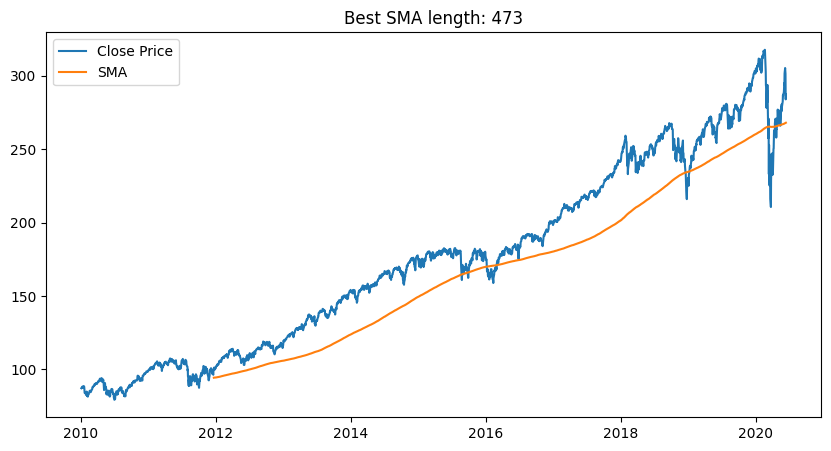

In [10]:
# plot the best sma ( with highest training forward return ) & SMA 20
plt.figure(figsize=(10,5))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA'], label='SMA')
plt.title('Best SMA length: ' + str(sma['sma_length']))
plt.legend()